# XGBoost

In [66]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, 
                            confusion_matrix, roc_auc_score,
                            RocCurveDisplay)

# Load and prepare data
combined_stocks_df = pd.read_csv("filtered_stocks_combined.csv")

# Convert Date to datetime and set as index
combined_stocks_df["Date"] = pd.to_datetime(combined_stocks_df["Date"])
combined_stocks_df.set_index("Date", inplace=True)

# Drop unnecessary columns if any
combined_stocks_df = combined_stocks_df.drop(columns=["index"])  # Optional

# Pivot to multi-level columns: Ticker as level 1, feature as level 2
stocks_df = combined_stocks_df.pivot_table(
    index=combined_stocks_df.index,
    columns="ticker",
    values=[col for col in combined_stocks_df.columns if col != "ticker"]
)

# Sort columns for clarity
stocks_df = stocks_df.sort_index(axis=1, level=0)

# Swap the column MultiIndex levels
stocks_df_leveled = stocks_df.swaplevel(axis=1)

# Sort by ticker (Level 0)
stocks_df_leveled = stocks_df_leveled.sort_index(axis=1, level=0)

#Time-based split into 60% train, 20% val, 20% test
train_dict, val_dict, test_dict = {}, {}, {}

# Time-based split into 60% train, 20% val, 20% test
train_dict, val_dict, test_dict = {}, {}, {}

# Compute Logarithmic Returns, split into train, val and test sets
for ticker in stocks_df_leveled.columns.levels[0]:
    stocks_df_leveled.loc[:, (ticker, 'log_return')] = np.log(
        stocks_df_leveled[ticker]['Close'] / stocks_df_leveled[ticker]['Close'].shift(1)
    )

    df = stocks_df_leveled[ticker].dropna().sort_index()
    total_len = len(df)
    train_end = int(total_len * 0.6)
    val_end = train_end + int(total_len * 0.2)

    train_dict[ticker] = df.iloc[:train_end]
    val_dict[ticker] = df.iloc[train_end:val_end]
    test_dict[ticker] = df.iloc[val_end:]

train_df = pd.concat(train_dict, names=["Ticker", "Date"])
val_df = pd.concat(val_dict, names=["Ticker", "Date"])
test_df = pd.concat(test_dict, names=["Ticker", "Date"])

In [67]:
# Define rolling window size
LOOKBACK_DAYS = 3

# Function to generate lagged features
def create_lagged_features(df, lookback_days):
    lagged_data = df.copy()
    
    # Create features for past 'lookback_days'
    for lag in range(1, lookback_days + 1):
        lagged_data[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    
    # Drop rows with NaN values due to shifting
    lagged_data.dropna(inplace=True)

    # Create binary classification target (1 = increase, 0 = decrease)
    lagged_data['Target'] = (lagged_data['log_return'].shift(-1) > 0).astype(int)
    
    return lagged_data

In [68]:
# Apply feature generation to all tickers
train_list, val_list, test_list = [], [], []

for ticker in train_dict.keys():
    # Generate lagged features
    train_lagged = create_lagged_features(train_dict[ticker], LOOKBACK_DAYS)
    val_lagged = create_lagged_features(val_dict[ticker], LOOKBACK_DAYS)
    test_lagged = create_lagged_features(test_dict[ticker], LOOKBACK_DAYS)

    # Store processed data
    train_list.append(train_lagged)
    val_list.append(val_lagged)
    test_list.append(test_lagged)

# Combine all tickers into a single dataset
train_df_final = pd.concat(train_list, axis=0)
val_df_final = pd.concat(val_list, axis=0)
test_df_final = pd.concat(test_list, axis=0)

# Separate features (X) and target (y)
X_train, y_train = train_df_final.drop(columns=['log_return', 'Target']), train_df_final['Target']
X_val, y_val = val_df_final.drop(columns=['log_return', 'Target']), val_df_final['Target']
X_test, y_test = test_df_final.drop(columns=['log_return', 'Target']), test_df_final['Target']

# Convert to DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

# Train XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'Validation')], early_stopping_rounds=10)

[0]	Validation-logloss:0.69310
[1]	Validation-logloss:0.69311
[2]	Validation-logloss:0.69308
[3]	Validation-logloss:0.69308
[4]	Validation-logloss:0.69308
[5]	Validation-logloss:0.69306
[6]	Validation-logloss:0.69304
[7]	Validation-logloss:0.69304
[8]	Validation-logloss:0.69304
[9]	Validation-logloss:0.69305
[10]	Validation-logloss:0.69306
[11]	Validation-logloss:0.69306
[12]	Validation-logloss:0.69305
[13]	Validation-logloss:0.69305
[14]	Validation-logloss:0.69304
[15]	Validation-logloss:0.69304
[16]	Validation-logloss:0.69303
[17]	Validation-logloss:0.69303
[18]	Validation-logloss:0.69304
[19]	Validation-logloss:0.69304
[20]	Validation-logloss:0.69304
[21]	Validation-logloss:0.69302
[22]	Validation-logloss:0.69304
[23]	Validation-logloss:0.69303
[24]	Validation-logloss:0.69303
[25]	Validation-logloss:0.69303
[26]	Validation-logloss:0.69303
[27]	Validation-logloss:0.69304
[28]	Validation-logloss:0.69305
[29]	Validation-logloss:0.69304
[30]	Validation-logloss:0.69304
[31]	Validation-lo

XGBoost Model Accuracy: 0.5121
XGBoost Model F1 Score: 0.6531
XGBoost Model AUC-ROC: 0.4924


Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down             792          6502
Actual Up               816          6890


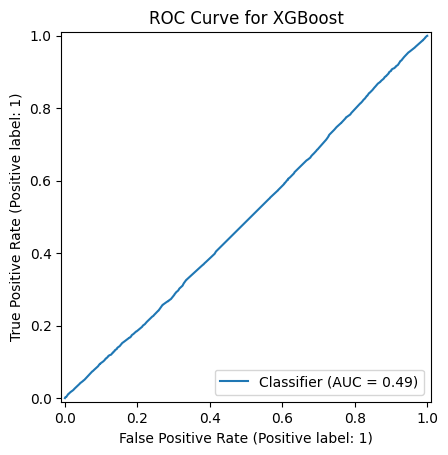

In [69]:
# Make predictions on the test set
y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"XGBoost Model Accuracy: {accuracy:.4f}")
print(f"XGBoost Model F1 Score: {f1:.4f}")
print(f"XGBoost Model AUC-ROC: {auc_roc:.4f}\n")

print("\nConfusion Matrix:")
print(pd.DataFrame(conf_matrix, 
                  index=['Actual Down', 'Actual Up'],
                  columns=['Predicted Down', 'Predicted Up']))

# Plot ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.title("ROC Curve for XGBoost")
plt.show()